# Importation des données

In [26]:
import os
import string
import re
import math
import statistics
from math import sqrt
import numpy as np
import random
import time
import pandas as pd
import nltk, re, pprint
#nltk.download('punkt')
from nltk import word_tokenize
random.seed(1)

import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

import pickle

#os.chdir('C:/Users/torna/Documents/StatApp/StatApp')
os.chdir('/Users/alainquartierlatente/Desktop/Ensae/StatApp')
#os.chdir('/home/aqlt/Documents/Ensae/StatApp')

On ne garde ici que les 100 000 premiers tweets

In [28]:
# Penser à changer selon taille
with open("data/corpus_trie100k.file", "rb") as f:
    corpus = pickle.load(f) 
ens_tweets = [phrase.split() for phrase in corpus]
phrases = ens_tweets
print(len(phrases))

9940


In [29]:
words = [item for sublist in phrases for item in sublist]
print(type(words))
vocabulary = list(dict.fromkeys(words))
with open("data/100k/vocabulary.file", "wb") as f:
    pickle.dump(vocabulary, f, pickle.HIGHEST_PROTOCOL)
index_mot = {index: w for (index, w) in enumerate(vocabulary)}
mot_index = {w: index for (index, w) in enumerate(vocabulary)}
print("Nombre de mots :", len(words))
print("Taille du vocabulaire :", len(vocabulary))

<class 'list'>
Nombre de mots : 111330
Taille du vocabulaire : 3215


Les 10 mots les plus communs sont :
[('lowfrequencyword', 12068), ('nickname', 7859), ('de', 3954), ('le', 2558), ('est', 2147), ('je', 2037), ('les', 1813), ('j', 1785), ('à', 1725), ('c', 1693)]


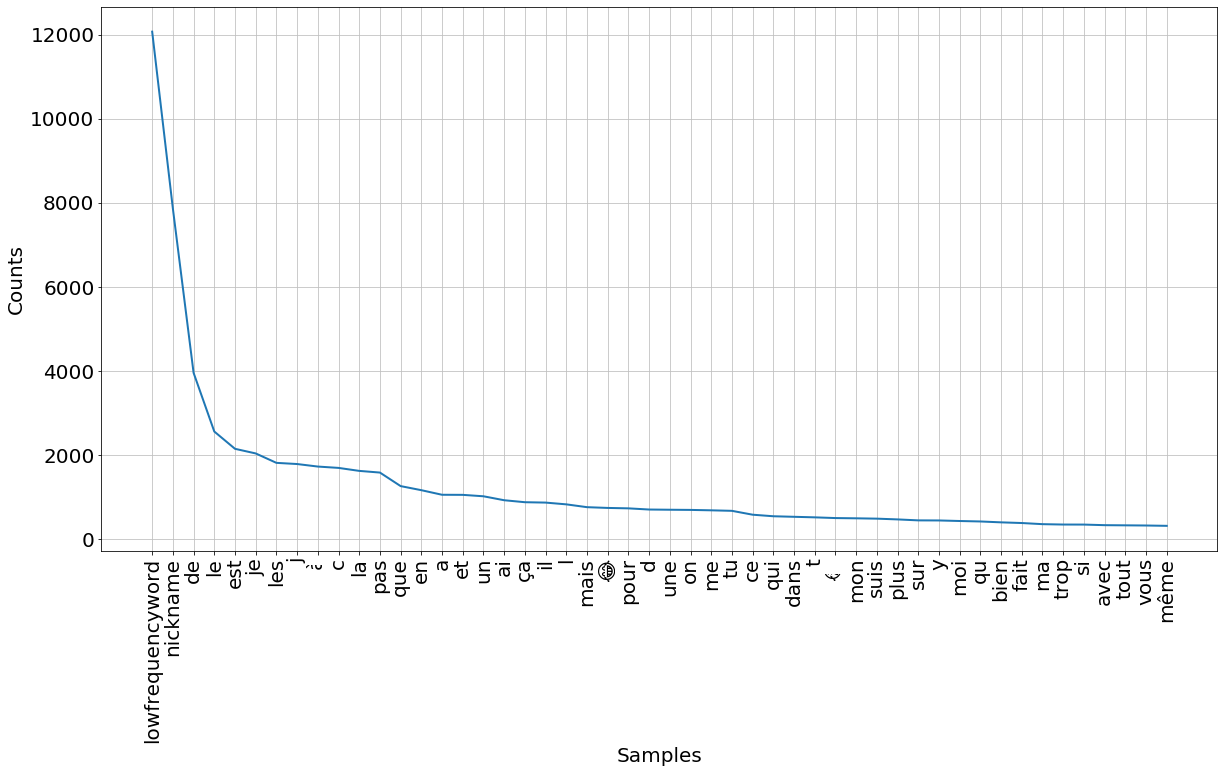

In [30]:
# Pour changer la taille des graphiques :
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["font.size"] = 20

fdist = nltk.FreqDist(words)
print("Les 10 mots les plus communs sont :")
print(fdist.most_common(10))
fdist.plot(50)

In [31]:
# Fonction pour mettre à jour le graphique en direct
def live_plot(data, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.plot(data)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.show();

In [32]:
def motContexteExiste(phrase, indice, focus, window):
    reponse = False
    debut = max(indice-window,0)
    fin = min(indice+window+1, len(phrase))
    for mot in phrase[debut:fin]:
        if mot != "subsampledword" and mot != "lowfrequencyword" and mot != focus:
            reponse = True
            break;
    return(reponse)

#Fonction pour vérifier si phrase OK ie si y a au moins un couple focus/context
def phraseVeri(phrase, window):
    phraseOk = False
    indice = -1
    for mot in phrase:
        indice = indice + 1
        if mot != "subsampledword" and mot != "lowfrequencyword":
            if(motContexteExiste(phrase,indice,mot,window)):
                phraseOk = True
                break;
    return(phraseOk)
listeTest = ["test","subsampledword","lowfrequencyword","ok","subsampledword"]
listeTestBis = ["test"]
print(phraseVeri(listeTest,2)) # Pas de couple focus/context pour une fenetre de 2
print(phraseVeri(listeTest,3)) # Il y a au moins un couple focus/context pour une fenetre de 3

False
True


# Sampling rate et negative sampling
On va simplifier un peu le corpus en enlevant certains mots. Pour cela on va faire un sous-échantillonnage du corpus pour supprimer certains mots. 

Pour chaque mot $w_i$ on note $z(w_i)$ la proportion d'apparition de ce mot, c'est-à-dire le rapport entre le nombre de fois que ce mot apparait et le nombre total de mots. La probabilité de garder un mot le mot $w_i$ est :
$$
\mathbb P(w_i) = \left(\sqrt{\frac{z(w_i)}{q}} + 1 \right)
\times
\frac{q}{z(w_i)}
$$
Le paramètre $q$ est appelé "sample" – échantillonnage – contrôle le nombre de sous-échantillonnages. La valeur par défaut est 0,001.

In [41]:
def calcul_proba(x):
    result = (sqrt(x)+1)*(1/x)
    return(result)
calcul_proba_v = np.vectorize(calcul_proba) # Pour vectoriser la fonction
# Fonction pour créer l'échantillon
def creer_echantillon(phrases, mot_index, probabilities_subsampling, window,
                    vec_neg_sampling, K = 5):
    #Sub-sampling
    def sub_sampling(phrase):
        res = []
        for word in phrase: #et pour tous les mots de l'article
        # Les mots à supprimer sont les mots tels que la loi générée U([0,1]) soit > proba
        # On garde donc les mots si U([0,1]) <= proba
            proba_w = probabilities_subsampling[mot_index[word]]
            if np.random.uniform(low=0.0, high=1.0) <= proba_w: # Je garde le mot
                res.append(word)
            else:
                res.append("subsampledword")
        return(res)
    nouveau_corpus = list(map(sub_sampling, phrases)) 
    #nouveau_corpus = Parallel(n_jobs=num_cores)(delayed(sub_sampling)(phrase) for phrase in phrases)

    phrases = [phrase for phrase in nouveau_corpus if phraseVeri(phrase,window)] # On enlève les phrases avec 1 seul mot
    def tirage_f_c(phrase):
        while True:
        # Pour chaque phrase on prend au hasard un mot focus et un mot contexte
            focus = np.random.randint(0, len(phrase))
            contexte = np.random.randint(max(focus-window,0),
                                       min(focus+window+1, len(phrase)))
            while(contexte == focus):
                contexte = np.random.randint(max(focus-window,0),
                                       min(focus+window+1, len(phrase)))
            if (phrase[focus] != "subsampledword" and phrase[focus] != "lowfrequencyword" 
                and phrase[contexte] != "subsampledword" and phrase[contexte] != "lowfrequencyword"):
                index_i = mot_index[phrase[focus]]
                index_j = mot_index[phrase[contexte]]
                neg_sample = tirage_neg_sampling(vec_neg_sampling, K = K)
                break
        return([index_i, index_j, neg_sample])
    #test_sample = Parallel(n_jobs=num_cores)(delayed(tirage_f_c)(phrase) for phrase in phrases)
    test_sample = map(tirage_f_c, phrases)
    return(list(test_sample))

sample = 0.001
proportion = np.array([(fdist[w]/ (len(words) * sample)) for w in vocabulary])
p_subsampling = calcul_proba_v(proportion) # C'est le vecteur contenant les proba de sub-sampling

Pour le négative sampling, la probabilité de garder le mot $w_i$ est égale à :
$$
\mathbb P(w_i) = \frac{f(w_i)^{3/4}}{
\sum_{j=1}^n f(w_j)^{3/4}
}
$$
Avec $f(w_j)$ la fréquence d'apparition du mot $w_j$.

In [34]:
p_negativesampling = np.array([(fdist[w]**(3/4)) for w in vocabulary])
p_negativesampling /= p_negativesampling.sum()

In [35]:
# Fonction de tirage des mots du negative sampling
#def tirage_neg_sampling(vocabulary, proba_negativesampling, focus, context, K = 5):
#    #proba_negativesampling[focus] = 0
#    #proba_negativesampling[context] = 0
#    liste_vocab = list(range(len(vocabulary)))
#    neg_sampling = np.random.choice(liste_vocab, size=K, p=proba_negativesampling)
#   # while( (focus in neg_sampling) | (context in neg_sampling)):
#   #     neg_sampling = np.random.choice(liste_vocab, size=K, p=proba_negativesampling)
#    return(neg_sampling)
def tirage_neg_sampling(vec_neg_sampling, K = 5):
    neg_sampling = vec_neg_sampling[np.random.randint(0, len(vec_neg_sampling), size = K)]
    return(neg_sampling)
def creation_vecteur_neg_sampling(p_negativesampling, taille_tot = 100000000):
    # On va créer un vecteur de taille environ égale à taille_tot où on va répéter 
    # p_negativesampling[i] * taille_tot chaque indice i
    # Par exemple, si taille_tot = 10, p_negativesampling = [0.5, 0.2, 0.3] on veut :
    # [0, 0, 0, 0, 0, 1, 1, 2, 2, 2]
    # Ensuite pour le négative sampling, on va tirer un élément au hasard de cette liste
    # qui va nous donner l'indice dans le vocabulaire du mot tiré par le négative sampling.
    # Dans l'exemple précédent on tire l'indice 0 avec une proba 0.5 (5 chance sur 10), c'est bien cohérent
    def rep_indice(i):
        # [i] * n répète n fois l'éléménet i
        return([i] * int(round(p_negativesampling[i] * taille_tot)))
    vec_neg_sampling = map(rep_indice, list(range(len(p_negativesampling))))
    vec_neg_sampling = list(vec_neg_sampling)
    # On veut un array à la fin, pour l'instant on a une liste de liste, si on reprend l'exemple précédent
    # on a : [[1, 1, 1, 1, 1], [2, 2], [3, 3, 3]]
    vec_neg_sampling = np.array([y for x in vec_neg_sampling for y in x], dtype = int)
    return(vec_neg_sampling)
vec_neg_sampling = creation_vecteur_neg_sampling(p_negativesampling, taille_tot = 100000000)

# Lancement du modèle
Paramètres fixés : la dimension, le nombre de mots tirés dans le *negative sampling* et la proba utilisé, l'affichage du graphique

In [43]:
dim = 50
K = 5
plot = True
epoch = 10

Paramètres à modifier :

In [37]:
learning_rate = 0.01
window = 3

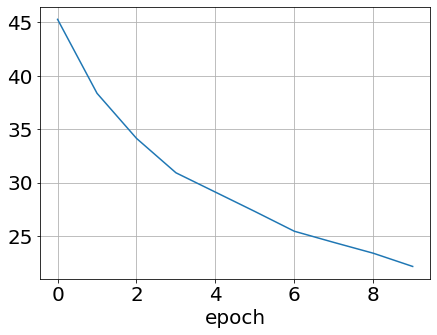

0.16
1.57
0.15504945556322733


In [42]:
input = torch.randn(len(vocabulary), dim)
output = torch.randn(len(vocabulary), dim)
input = autograd.Variable(input, requires_grad=True)
output = autograd.variable(output, requires_grad=True)

loss_tot = []
temps_par_epoch = []

start = time.time()
for i in range(epoch):
    loss_val = 0
    start_epoch = time.time()
#    test_sample = creer_echantillon(phrases, mot_index, p_subsampling, window,
#                                         vocabulary, p_negativesampling, K = K)
    test_sample = creer_echantillon(phrases, mot_index, p_subsampling, window,
                                         vec_neg_sampling, K = K)
    for focus, context, neg_sample in test_sample:
        #vect_sample = np.append(context, neg_sample)
        data = torch.matmul(input[focus,], torch.t(output[context,]))
        loss1 = - F.logsigmoid(data)

        data = torch.matmul(input[focus,], torch.t(output[neg_sample,]))
        loss2 = - F.logsigmoid(-data).sum()
        loss_val += loss1 + loss2
        # Pour ensuite dériver les matrices par rapport à la loss
        (loss1+loss2).backward()

        # Il faut modifier juste le .data pour ne pas perdre la structure
        input.data = input.data - learning_rate * input.grad.data
        output.data = output.data - learning_rate * output.grad.data

        input.grad.data.zero_()
        output.grad.data.zero_()
        
    with open("data/100k/input_%i.file" %(len(loss_tot)+1), "wb") as f:
        pickle.dump(input, f, pickle.HIGHEST_PROTOCOL)
    with open("data/100k/output_%i.file" %(len(loss_tot)+1), "wb") as f:
        pickle.dump(output, f, pickle.HIGHEST_PROTOCOL)
    with open("data/100k/loss.file", "wb") as f:
        pickle.dump(loss_tot, f, pickle.HIGHEST_PROTOCOL)
    with open("data/100k/temps_par_epoch.file", "wb") as f:
        pickle.dump(temps_par_epoch, f, pickle.HIGHEST_PROTOCOL)
        
    end_epoch = time.time()
    temps_par_epoch.append(end_epoch - start_epoch)
    loss_val = loss_val / len(vocabulary)
    loss_tot.append(loss_val)
    if plot:
        live_plot(loss_tot)
    print(round((end_epoch - start_epoch)/60, 2))
end = time.time()
print(round((end - start)/60, 2))
print(statistics.mean(temps_par_epoch)/60)